In [325]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

In [326]:
df = pd.read_csv("final.csv")

In [327]:
df

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669.0,9656.0,7561.0,214.0,2674.0,1338.0
1,2,3,7057.0,9810.0,9568.0,1762.0,3293.0,1776.0
2,2,3,6353.0,8808.0,7684.0,2405.0,3516.0,7844.0
3,1,3,13265.0,1196.0,4221.0,6404.0,507.0,1788.0
4,2,3,22615.0,5410.0,7198.0,NaN,1777.0,NaN
...,...,...,...,...,...,...,...,...
435,1,3,29703.0,12051.0,16027.0,13135.0,182.0,2204.0
436,1,3,39228.0,1431.0,764.0,4510.0,93.0,2346.0
437,2,3,14531.0,15488.0,30243.0,437.0,14841.0,1867.0
438,1,3,10290.0,1981.0,2232.0,1038.0,168.0,2125.0


In [328]:
np.count_nonzero(df.isnull()) # 9 nulls

9

In [329]:
set(df["Channel"]) # we have two categorical values, 1 and 2. Let's relace the null values with their correspondong means

{1, 2}

In [330]:
def fill_na(s): # s will be a chunk of the group by object
    avg = s.mean()
    return(s.fillna(avg))


for col in df.columns:
    df[col] = df.groupby("Channel")[col].transform(fill_na)

In [331]:
np.count_nonzero(df.isnull()) # clean

0

In [332]:
df

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669.0,9656.0,7561.0,214.000000,2674.0,1338.000000
1,2,3,7057.0,9810.0,9568.0,1762.000000,3293.0,1776.000000
2,2,3,6353.0,8808.0,7684.0,2405.000000,3516.0,7844.000000
3,1,3,13265.0,1196.0,4221.0,6404.000000,507.0,1788.000000
4,2,3,22615.0,5410.0,7198.0,1639.978571,1777.0,1729.099291
...,...,...,...,...,...,...,...,...
435,1,3,29703.0,12051.0,16027.0,13135.000000,182.0,2204.000000
436,1,3,39228.0,1431.0,764.0,4510.000000,93.0,2346.000000
437,2,3,14531.0,15488.0,30243.0,437.000000,14841.0,1867.000000
438,1,3,10290.0,1981.0,2232.0,1038.000000,168.0,2125.000000


In [333]:
# lets test our data with box plots on the subjects of outliers

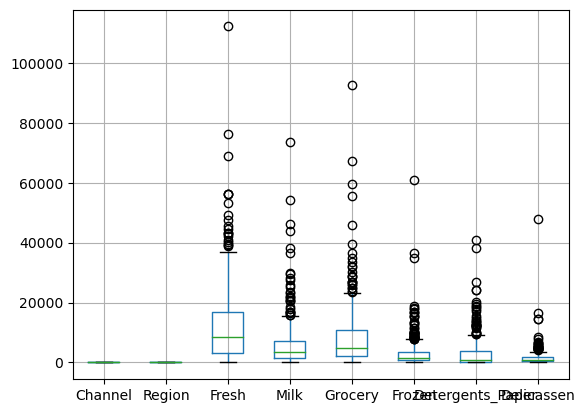

In [334]:
df.boxplot()
plt.show()

In [335]:
# as we can see for numeric values we have some ourliers (values above the prescribed max in the box plot)
# and also we will have to normalize the data! 

In [336]:
# probably you saw this class in my previous assigns...

In [337]:
class OutlierRemover(BaseEstimator,TransformerMixin): # our own class to remove outliers - we will insert it to the pipeline
    
    def __init__(self,factor=1.5):
        self.factor = factor # higher the factor, extreme would be the outliers removed.
        
    def outlier_detector(self,X,y=None):
        X = pd.Series(X).copy()
        q1 = X.quantile(0.25)
        q3 = X.quantile(0.75)
        iqr = q3 - q1
        self.lower_bound.append(q1 - (self.factor * iqr)) 
        self.upper_bound.append(q3 + (self.factor * iqr))
        self.median.append(X.median())

    def fit(self,X,y=None): # for each coulmn we will append corresponding boundary and the median value
        self.median = []
        self.lower_bound = []
        self.upper_bound = []
        X.apply(self.outlier_detector)
        return self
    
    def transform(self,X,y=None): # then, with transform we will check is a value goes beyond the boundary, if so we replace it
        X = pd.DataFrame(X).copy()
        for i in range(X.shape[1]):
            x = X.iloc[:, i].copy() # change the copy
            x[(x < self.lower_bound[i]) | (x > self.upper_bound[i])] = self.median[i] # replace outliers with the median
            X.iloc[:, i] = x # make the column copy

        return X # our transformed df

In [338]:
ct = OutlierRemover()
sl = StandardScaler()

data_prep = Pipeline(steps = [["outlier_removal",ct],['scalar', sl]])

d = data_prep.fit_transform(df)

df = pd.DataFrame(d, columns = df.columns)

In [339]:
df # Yes! now we are good to go to apply k means

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,1.448652,0.590668,0.311714,1.575679,0.247090,-1.006019,0.386501,0.299958
1,1.448652,0.590668,-0.353221,1.620929,0.621838,-0.078908,0.660891,0.821381
2,1.448652,0.590668,-0.436634,1.326509,0.270057,0.306191,0.759743,-0.143489
3,-0.690297,0.590668,0.382330,-0.910145,-0.376556,2.701228,-0.574087,0.835666
4,1.448652,0.590668,1.490160,0.328066,0.179310,-0.151987,-0.011122,0.765547
...,...,...,...,...,...,...,...,...
435,-0.690297,0.590668,2.329977,2.279408,1.827865,-0.213063,-0.718153,1.330898
436,-0.690297,0.590668,-0.176442,-0.841094,-1.022048,1.566894,-0.757605,1.499944
437,1.448652,0.590668,0.532332,3.289311,-0.276754,-0.872462,-0.438887,0.929713
438,-0.690297,0.590668,0.029839,-0.679486,-0.747943,-0.512518,-0.724359,1.236852


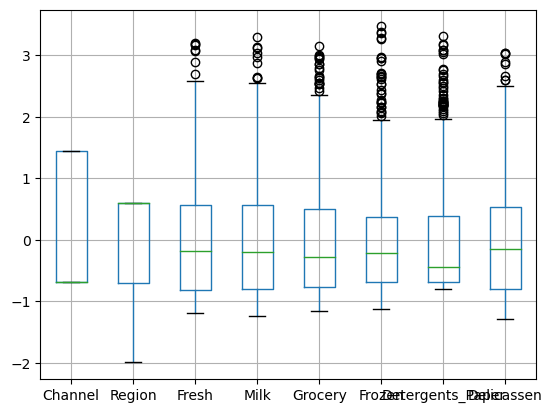

In [340]:
df.boxplot() # normalized, less outliers
plt.show()

In [341]:
# as for beginning lets run the algo just with the random centroids

In [342]:
k = 3 # let's say k=3
kmeans = KMeans(n_clusters=k, init="random")

In [343]:
y_pred = kmeans.fit_predict(df)

In [344]:
y_pred # we have some result, but is it optimal?

array([2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1,
       0, 2, 2, 2, 1, 1, 2, 1, 0, 1, 1, 0, 1, 2, 0, 2, 2, 0, 0, 0, 2, 2,
       2, 2, 2, 1, 2, 1, 0, 1, 2, 2, 0, 1, 1, 2, 1, 1, 2, 0, 2, 2, 1, 1,
       1, 2, 0, 1, 1, 0, 1, 2, 2, 0, 0, 2, 1, 1, 1, 2, 2, 0, 2, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 2, 1, 2, 1, 1, 0, 2, 2, 2, 0, 1, 1, 2, 2, 2, 1,
       1, 2, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 2, 0, 1, 1, 2, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 2, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 2, 2, 0, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2,
       0, 0, 1, 0, 0, 2, 2, 0, 1, 1, 1, 0, 2, 2, 0, 1, 1, 2, 1, 0, 0, 2,
       0, 1, 2, 2, 0, 1, 1, 2, 1, 2, 1, 2, 0, 0, 1, 1, 2, 2, 1, 0, 2, 1,
       0, 2, 0, 0, 1, 1, 2, 1, 1, 0, 2, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 2, 2, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       2, 0, 2, 0, 2, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 2, 1, 2, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 0, 2, 2, 1, 2,

In [345]:
# for the determination of the optimal k we will use two methods:
# a) plot vs inertia (not stable metric)
# b) use silhouette score

In [346]:
def analyze_k(X,mes="iner",ran=True):
    metric = []

    for i in range(2,11):
        k = i
        if ran is True:
            kmeans = KMeans(n_clusters=k,init="random",random_state=42) # random k-means
        else:
            kmeans = KMeans(n_clusters=k,random_state=42) # k-means++
        kmeans.fit(X)
        if mes == "iner":
            metric.append(kmeans.inertia_)
        else:
            metric.append(silhouette_score(X, kmeans.labels_))

    print(metric)
    print()
    if mes != "iner":
        print(f"maximum silhouette_score of {max(metric)} for the k of {metric.index(max(metric))+2}")
        print()
    plt.plot(range(2,len(metric)+2),metric)
    plt.show()

[2476.4218250591653, 2175.6699883831266, 1942.1550081893158, 1769.6103767312184, 1622.1136950205787, 1531.556505893092, 1441.1242666619855, 1371.851650703011, 1302.849167609242]



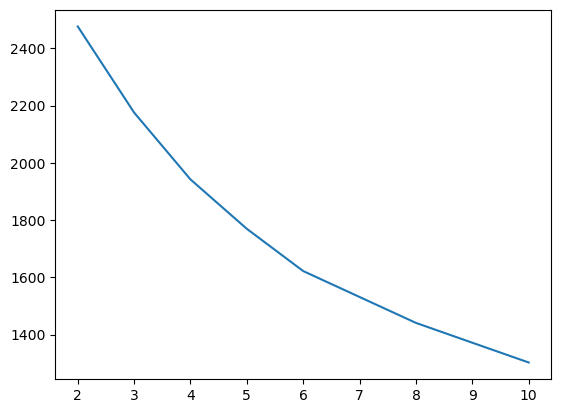

In [347]:
analyze_k(df) # random centroid initializer, inertia score

In [348]:
# it seems that 4-5 might be reasoble choice, let's see what silhouette score will give us
# we know that as long as we increase the number of clusters (k), the inirtia will be lower and lower up to 0,
# if k = number of records in our dataset

[0.3139937508176235, 0.21798110239075813, 0.21837394438940355, 0.23156207531636291, 0.20943402800022146, 0.21697477429865247, 0.21320694592653924, 0.22082029261243832, 0.21784982159806152]

maximum silhouette_score of 0.3139937508176235 for the k of 2



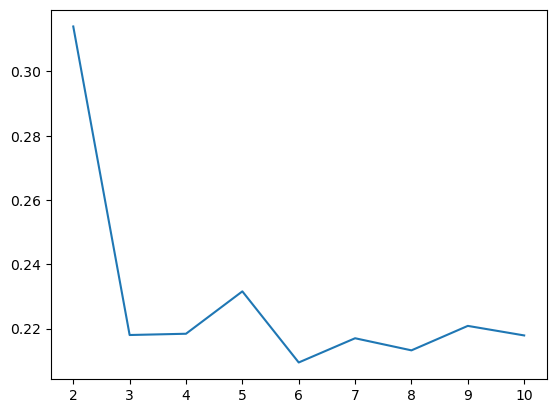

In [349]:
analyze_k(df, "silhouette_score") # random centroid initializer, silhouette_score

In [350]:
# it apperas that the score was the highest at k = 2

In [351]:
kmeans = KMeans(n_clusters=2,init="random",random_state=42)
y_pred = kmeans.fit_predict(df)

In [352]:
y_pred = list(y_pred)
for clust in set(y_pred):
    print(f"cluster {clust}: {y_pred.count(clust)} instances")

cluster 0: 306 instances
cluster 1: 134 instances


In [353]:
# kmeans ++ is actually set by default in k-means from skelearn. We specified "random", but we will not use this

[2476.4218250591653, 2168.929836905946, 1952.4930505825391, 1775.4927345383946, 1623.9774258048863, 1535.0132755257312, 1459.1079229684483, 1369.6150142224246, 1320.569519742445]



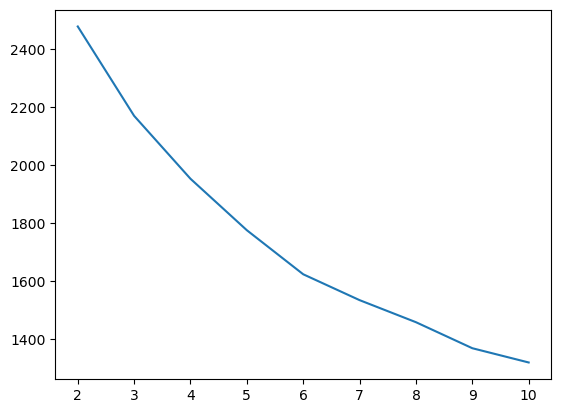

In [354]:
analyze_k(df, ran=False) # k-mean ++ initializer, inertia score

[0.3139937508176235, 0.2435225250845019, 0.21748691129987963, 0.21859506598583545, 0.2091307493004431, 0.21147048258728282, 0.21288979827889107, 0.22177666244786184, 0.21296460783218166]

maximum silhouette_score of 0.3139937508176235 for the k of 2



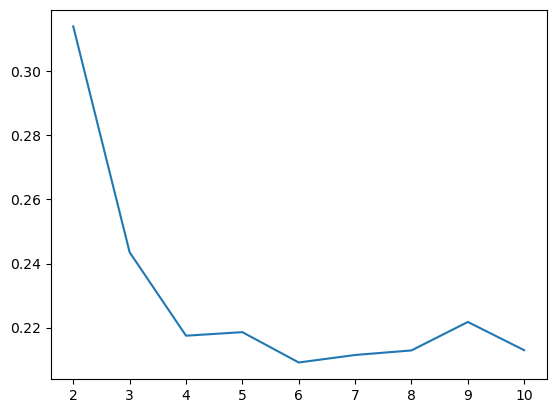

In [355]:
analyze_k(df, mes="silhouette_score",ran=False) # k-mean ++ initializer", silhouette_score

In [356]:
 # again, k=2 seems to be optimal choice

In [357]:
kmeans = KMeans(n_clusters=2,random_state=42)
y_pred = kmeans.fit_predict(df)

y_pred = list(y_pred)
for clust in set(y_pred):
    print(f"cluster {clust}: {y_pred.count(clust)} instances")

cluster 0: 134 instances
cluster 1: 306 instances


In [358]:
# the end!